In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error 
import numpy as np

# Cargar los datos
df = pd.read_csv('datasets/Depurados/TLC Aggregated Data/merged_taxi_data.csv')

# Convertir la columna de fecha
df['date'] = pd.to_datetime(df['date'])

# Filtrar y seleccionar las columnas necesarias
df_mvp = df[['date', 'industry', 'unique_vehicles', 'farebox_per_day', 'trips_per_day','total_trips', 'avg_trip_distance', 'avg_trip_duration', 'total_amount', 'farebox_per_day_per_distance', 'total_co2_emission']]

# Filtrar por industria
df_filtered = df_mvp[df['industry'].isin(['FHV - High Volume'])].copy()

# Agrupar por mes y calcular la suma de la columna de interés
df_mensual = df_filtered.resample('ME', on='date').sum().reset_index()



In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   date                                    176 non-null    datetime64[ns]
 1   industry                                176 non-null    object        
 2   trips_per_day                           176 non-null    int64         
 3   farebox_per_day                         132 non-null    float64       
 4   unique_drivers                          176 non-null    int64         
 5   unique_vehicles                         176 non-null    int64         
 6   vehicles_per_day                        176 non-null    int64         
 7   avg_days_vehicles_on_road               176 non-null    float64       
 8   avg_hours_per_day_per_vehicle           176 non-null    float64       
 9   avg_days_drivers_on_road                176 non-null  

In [11]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 0 to 172
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          44 non-null     datetime64[ns]
 1   industry                      44 non-null     object        
 2   unique_vehicles               44 non-null     int64         
 3   farebox_per_day               44 non-null     float64       
 4   trips_per_day                 44 non-null     int64         
 5   total_trips                   44 non-null     int64         
 6   avg_trip_distance             44 non-null     float64       
 7   avg_trip_duration             44 non-null     float64       
 8   total_amount                  44 non-null     float64       
 9   farebox_per_day_per_distance  44 non-null     float64       
 10  total_co2_emission            44 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int6

**Cantidad de Vehículos**

11:01:41 - cmdstanpy - INFO - Chain [1] start processing
11:01:41 - cmdstanpy - INFO - Chain [1] done processing


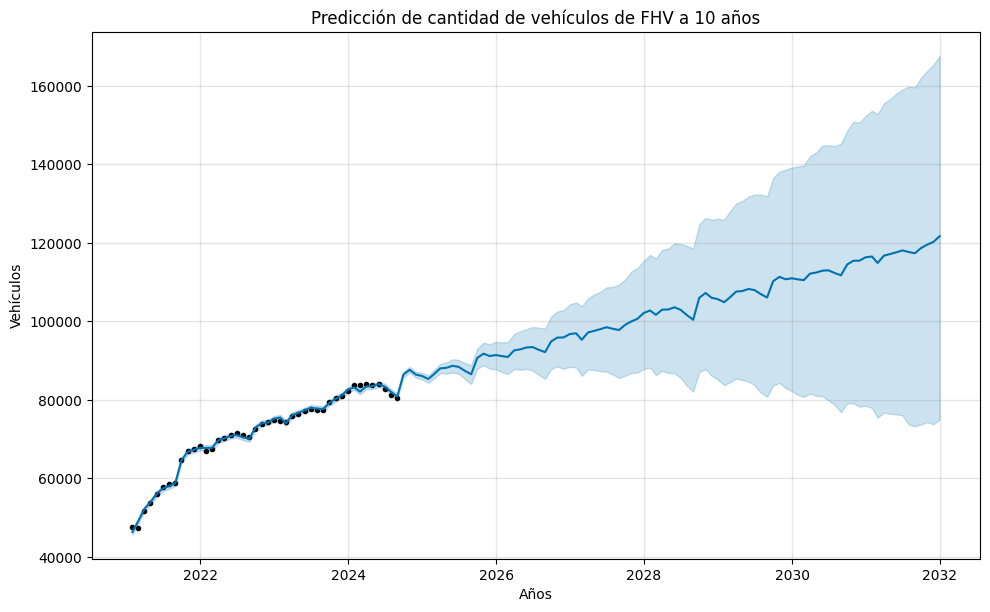

In [12]:
# Renombrar la columna de fecha y la columna de valor a predecir
df_vehicles = df_mensual.rename(columns={'date': 'ds', 'unique_vehicles': 'y'})  # Datos de vehículos mensuales

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(df_vehicles)

# Crear un dataframe con las fechas futuras para la predicción
future_dates = model.make_future_dataframe(periods=88, freq='ME')
forecast = model.predict(future_dates)

# Visualizar la predicción
fig = model.plot(forecast)
plt.xlabel('Años')
plt.ylabel('Vehículos')
plt.title('Predicción de cantidad de vehículos de FHV a 10 años')
plt.show()



**Evaluación con Datos Históricos**

In [13]:
y_true = df_vehicles['y']  # Valores reales
y_pred = forecast.loc[forecast['ds'].isin(df_vehicles['ds']), 'yhat']  # Predicciones en las fechas reales

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")


MAE: 401.05369415400406
RMSE: 554.895542735368
MAPE: 0.00599441315069095


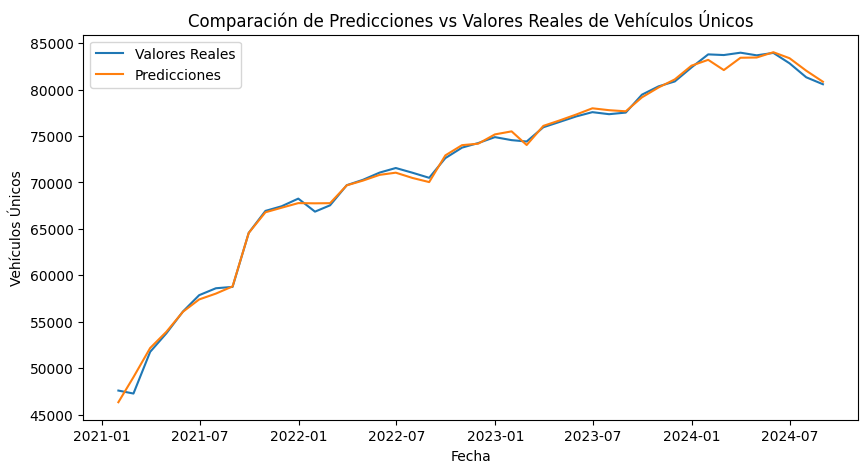

In [14]:
import matplotlib.pyplot as plt

# Visualizar las predicciones junto con los valores reales
plt.figure(figsize=(10, 5))
plt.plot(df_vehicles['ds'], df_vehicles['y'], label='Valores Reales')
plt.plot(df_vehicles['ds'], y_pred, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Vehículos Únicos')
plt.title('Comparación de Predicciones vs Valores Reales de Vehículos Únicos')
plt.legend()
plt.show()


1. Mean Absolute Error (MAE)
Definición:

El MAE mide el error promedio entre las predicciones y los valores reales, tomando la media de las diferencias absolutas.

Fórmula: $$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|$$

Interpretación:

Valores bajos indican que el modelo tiene predicciones más precisas en promedio.

Valores altos sugieren mayores diferencias entre las predicciones y los valores reales.

2. Mean Squared Error (MSE)
Definición:

El MSE mide el promedio de los errores al cuadrado entre las predicciones y los valores reales. Penaliza más los errores grandes debido a la cuadratura.

Fórmula: $$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2$$

Interpretación:

Valores bajos indican que las predicciones están cerca de los valores reales en promedio.

Valores altos indican mayores errores, especialmente errores grandes.

3. Root Mean Squared Error (RMSE)
Definición:

El RMSE es la raíz cuadrada del MSE y está en la misma escala que los valores originales, lo que facilita la interpretación.

Fórmula: $$\text{RMSE} = \sqrt{\text{MSE}}$$

Interpretación:

Valores bajos indican una mejor precisión del modelo.

Valores altos indican una mayor variabilidad y errores.

4. Mean Absolute Percentage Error (MAPE)
Definición:

El MAPE mide el error absoluto promedio en forma de porcentaje, lo que facilita la comparación entre diferentes datasets.

Fórmula: $$\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100$$

Interpretación:

Valores bajos (cercanos a 0%) indican que el modelo es muy preciso.

Valores altos indican una mayor variabilidad y errores relativos.

In [15]:
vehicles_count = df_vehicles['y'].unique()
vehicles_count

array([47594, 47272, 51761, 53748, 56112, 57863, 58607, 58754, 64572,
       66935, 67433, 68257, 66855, 67536, 69702, 70281, 71059, 71552,
       71043, 70497, 72616, 73747, 74237, 74877, 74553, 74404, 75941,
       76511, 77106, 77565, 77346, 77520, 79448, 80346, 80871, 82379,
       83785, 83713, 83966, 83683, 83944, 82824, 81319, 80570])

**Validación Cruzada (Time Series Split)**

In [16]:
#from sklearn.model_selection import TimeSeriesSplit
#from sklearn.metrics import mean_absolute_error, mean_squared_error

# Crear la función de validación cruzada
#tscv = TimeSeriesSplit(n_splits=3)  # Puedes ajustar el número de splits según sea necesario

#mae_scores = []
#mse_scores = []

#for train_index, test_index in tscv.split(df_vehicles):
#    train, test = df_vehicles.iloc[train_index], df_vehicles.iloc[test_index]
    
    # Entrenar el modelo con los datos de entrenamiento
#    model = Prophet()
#    model.fit(train)
    
    # Realizar las predicciones
#    future_dates = model.make_future_dataframe(periods=len(test), freq='ME')
#    forecast = model.predict(future_dates)
    
    # Evaluar el modelo
#    test = test.copy()
#    test['yhat'] = forecast['yhat'].iloc[-len(test):].values
#    test_clean = test.dropna(subset=['y', 'yhat'])
    
#    mae = mean_absolute_error(test_clean['y'], test_clean['yhat'])
#    mse = mean_squared_error(test_clean['y'], test_clean['yhat'])
    
#    mae_scores.append(mae)
#    mse_scores.append(mse)

#print(f'Mean Absolute Error (MAE): {np.mean(mae_scores)}')
#print(f'Mean Squared Error (MSE): {np.mean(mse_scores)}')


**Cantidad de viajes**

11:01:42 - cmdstanpy - INFO - Chain [1] start processing
11:01:42 - cmdstanpy - INFO - Chain [1] done processing


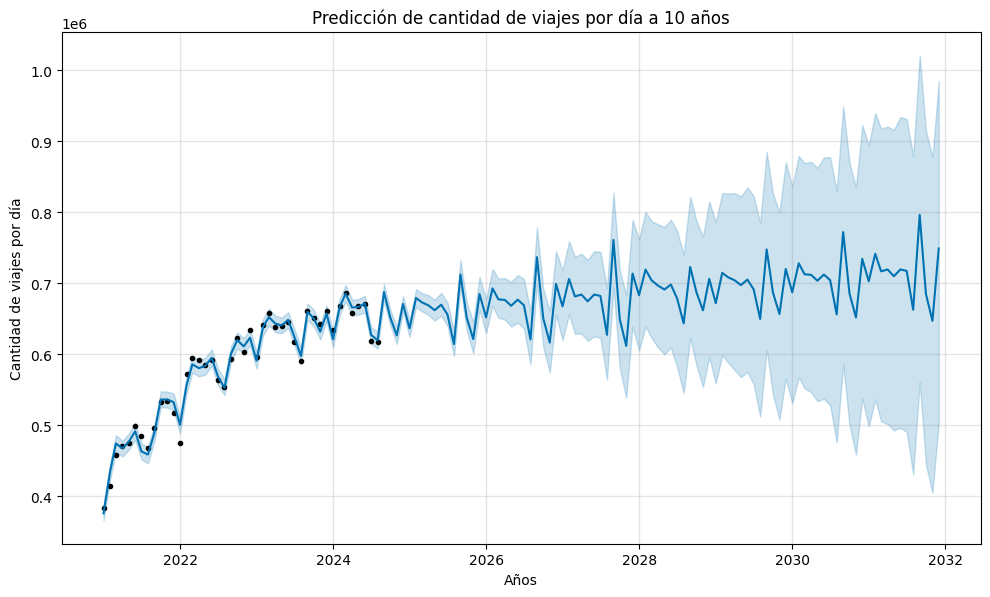

In [17]:
# Convertir el dataframe al formato requerido por Prophet
df_trips = df_filtered.rename(columns={'date': 'ds', 'trips_per_day': 'y'})

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(df_trips)

# Crear un dataframe con las fechas futuras para la predicción
future_dates = model.make_future_dataframe(periods=88, freq='ME')
forecast = model.predict(future_dates)

# Visualizar la predicción
fig = model.plot(forecast)
plt.xlabel('Años')
plt.ylabel('Cantidad de viajes por día')
plt.title('Predicción de cantidad de viajes por día a 10 años')
plt.show()

In [18]:
y_true = df_trips['y']  # Valores reales
y_pred = forecast.loc[forecast['ds'].isin(df_trips['ds']), 'yhat']  # Predicciones en las fechas reales

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 6850.662430795443
RMSE: 9021.020988424152
MAPE: 0.012741433154820703


In [19]:
trips_count = df_trips['y'].unique()
trips_count

array([383951, 414782, 458946, 470377, 474809, 498685, 484745, 467654,
       496112, 533649, 534718, 517884, 475854, 572114, 595270, 591746,
       585714, 592656, 563353, 554361, 593114, 622770, 602819, 634379,
       596095, 641461, 658499, 638161, 640244, 645549, 617161, 591032,
       661698, 651179, 642308, 661815, 634329, 667560, 686479, 657765,
       667886, 670772, 618802, 617043])

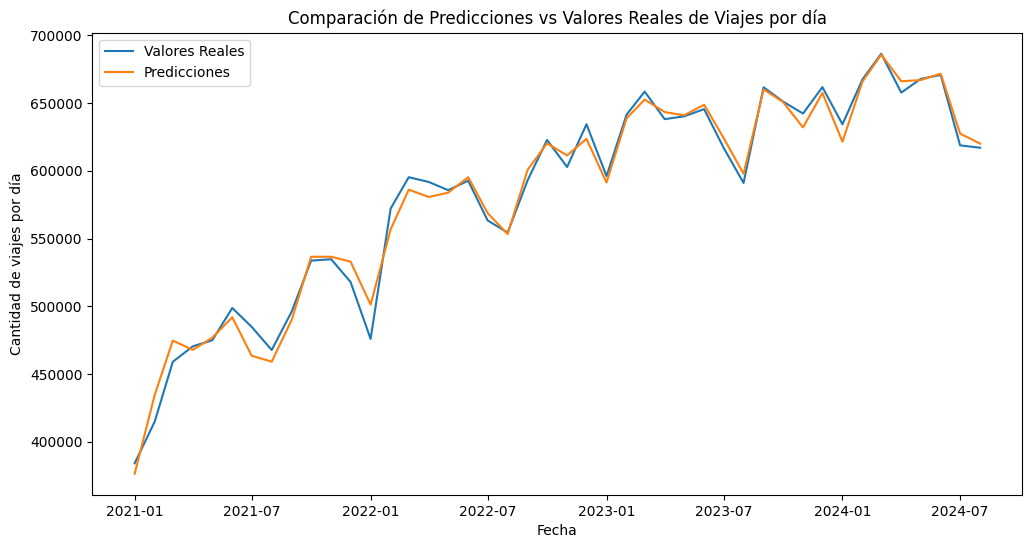

In [20]:
# Visualizar las predicciones junto con los valores reales
plt.figure(figsize=(12, 6))
plt.plot(df_trips['ds'], df_trips['y'], label='Valores Reales')
plt.plot(df_trips['ds'], y_pred, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de viajes por día')
plt.title('Comparación de Predicciones vs Valores Reales de Viajes por día')
plt.legend()
plt.show()

**Evolución de distancia en millas**

11:01:43 - cmdstanpy - INFO - Chain [1] start processing
11:01:43 - cmdstanpy - INFO - Chain [1] done processing


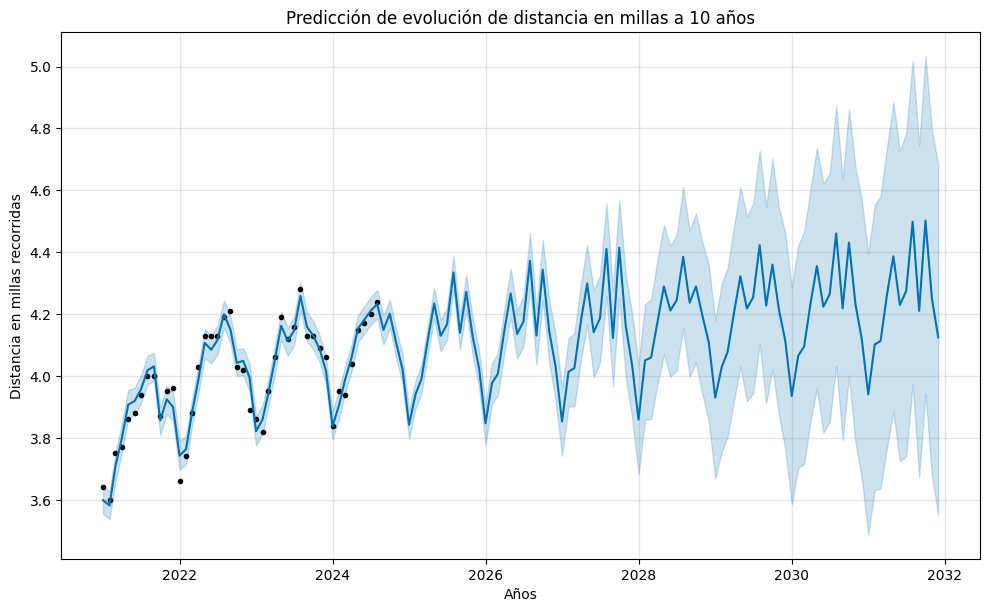

In [21]:
# Convertir el dataframe al formato requerido por Prophet
df_distance = df_filtered.rename(columns={'date': 'ds', 'avg_trip_distance': 'y'})

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(df_distance)

# Crear un dataframe con las fechas futuras para la predicción
future_dates = model.make_future_dataframe(periods=88, freq='ME')
forecast = model.predict(future_dates)

# Visualizar la predicción
fig = model.plot(forecast)
plt.xlabel('Años')
plt.ylabel('Distancia en millas recorridas')
plt.title('Predicción de evolución de distancia en millas a 10 años')
plt.show()

In [22]:
y_true = df_distance['y']  # Valores reales
y_pred = forecast.loc[forecast['ds'].isin(df_distance['ds']), 'yhat']  # Predicciones en las fechas reales

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 0.027691789870338077
RMSE: 0.035250438095585014
MAPE: 0.007030578428766152


In [23]:
distance_count = df_distance['y'].unique()
distance_count

array([3.64, 3.6 , 3.75, 3.77, 3.86, 3.88, 3.94, 4.  , 3.87, 3.95, 3.96,
       3.66, 3.74, 4.03, 4.13, 4.19, 4.21, 4.02, 3.89, 3.82, 4.06, 4.12,
       4.16, 4.28, 4.09, 3.84, 4.04, 4.15, 4.17, 4.2 , 4.24])

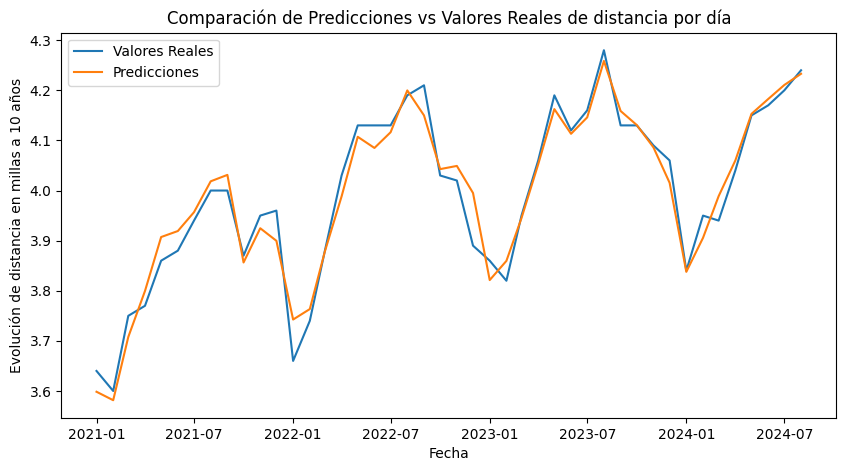

In [24]:
# Visualizar las predicciones junto con los valores reales
plt.figure(figsize=(10, 5))
plt.plot(df_distance['ds'], df_distance['y'], label='Valores Reales')
plt.plot(df_distance['ds'], y_pred, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Evolución de distancia en millas a 10 años')
plt.title('Comparación de Predicciones vs Valores Reales de distancia por día')
plt.legend()
plt.show()

**Tarifa por milla**

11:01:43 - cmdstanpy - INFO - Chain [1] start processing
11:01:44 - cmdstanpy - INFO - Chain [1] done processing


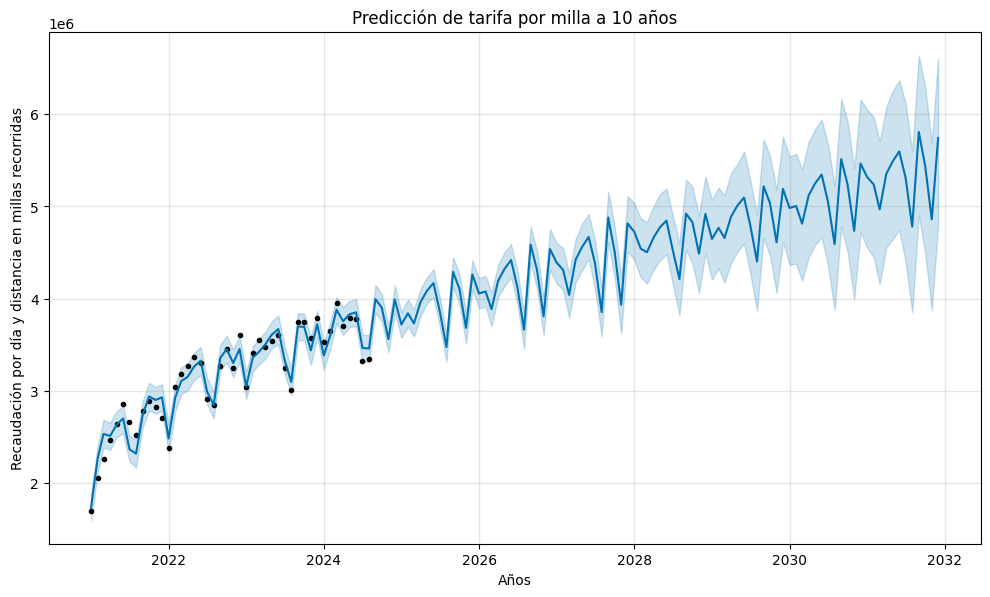

In [25]:
# Convertir el dataframe al formato requerido por Prophet
df_farebox = df_filtered.rename(columns={'date': 'ds', 'farebox_per_day_per_distance': 'y'})

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(df_farebox)

# Crear un dataframe con las fechas futuras para la predicción
future_dates = model.make_future_dataframe(periods=88, freq='ME')
forecast = model.predict(future_dates)

# Visualizar la predicción
fig = model.plot(forecast)
plt.xlabel('Años')
plt.ylabel('Recaudación por día y distancia en millas recorridas')
plt.title('Predicción de tarifa por milla a 10 años')
plt.show()

In [26]:
y_true = df_farebox['y']  # Valores reales
y_pred = forecast.loc[forecast['ds'].isin(df_farebox['ds']), 'yhat']  # Predicciones en las fechas reales

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 91137.38788942773
RMSE: 113946.17626983997
MAPE: 0.0310436946164831


In [27]:
farebox_count = df_farebox['y'].unique()
farebox_count

array([1699251.6269, 2053578.6945, 2260062.7926, 2470862.4564,
       2636233.504 , 2860320.948 , 2664216.521 , 2525471.3497,
       2776763.4707, 2887077.7825, 2823918.9632, 2709533.0401,
       2379661.0398, 3044299.8163, 3187123.697 , 3275112.8773,
       3366156.4236, 3301472.1715, 2916127.5425, 2847682.8917,
       3274006.0442, 3454782.6163, 3249783.6126, 3609072.0242,
       3039472.1339, 3409454.3939, 3546390.2282, 3477331.0967,
       3541225.2487, 3609731.9248, 3249246.6124, 3006262.6626,
       3742872.6926, 3743694.2981, 3568425.6054, 3787384.7294,
       3529837.9318, 3645542.5774, 3947989.9392, 3703390.6352,
       3792178.2498, 3779401.2223, 3324663.5885, 3343549.6348])

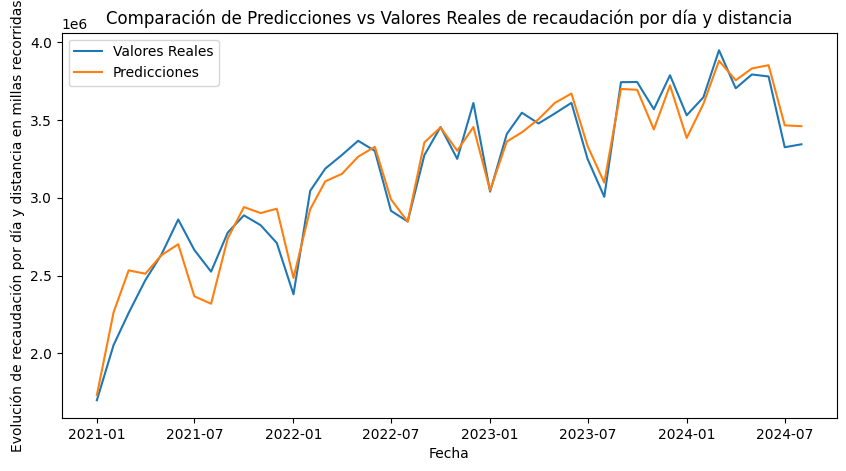

In [28]:
# Visualizar las predicciones junto con los valores reales
plt.figure(figsize=(10, 5))
plt.plot(df_farebox['ds'], df_farebox['y'], label='Valores Reales')
plt.plot(df_farebox['ds'], y_pred, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Evolución de recaudación por día y distancia en millas recorridas')
plt.title('Comparación de Predicciones vs Valores Reales de recaudación por día y distancia')
plt.legend()
plt.show()

**Tarifa general**

11:01:44 - cmdstanpy - INFO - Chain [1] start processing
11:01:45 - cmdstanpy - INFO - Chain [1] done processing


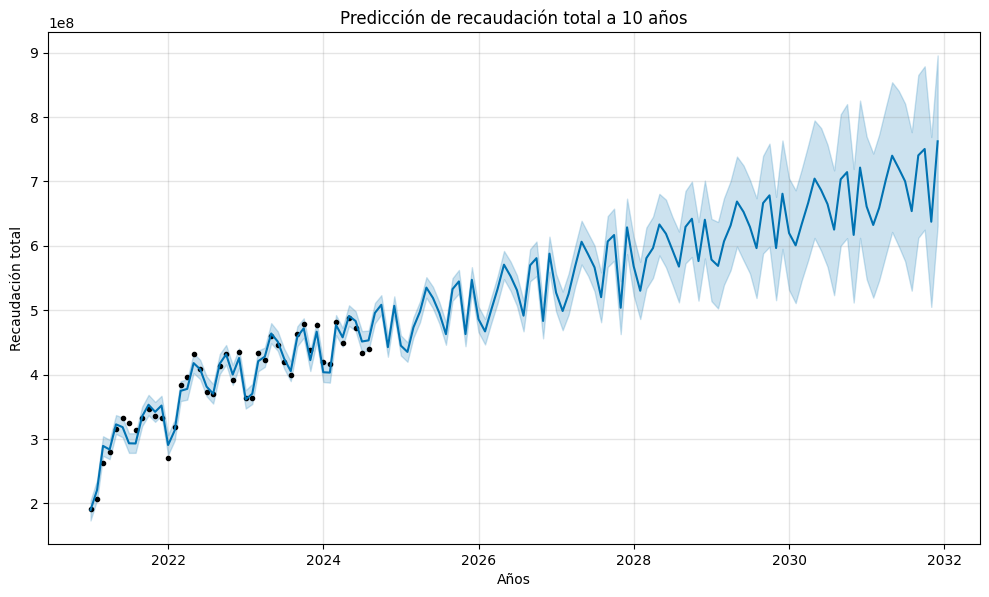

In [29]:
# Convertir el dataframe al formato requerido por Prophet
df_amount = df_filtered.rename(columns={'date': 'ds', 'total_amount': 'y'})

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(df_amount)

# Crear un dataframe con las fechas futuras para la predicción
future_dates = model.make_future_dataframe(periods=88, freq='ME')
forecast = model.predict(future_dates)

# Visualizar la predicción
fig = model.plot(forecast)
plt.xlabel('Años')
plt.ylabel('Recaudación total')
plt.title('Predicción de recaudación total a 10 años')
plt.show()

In [30]:
y_true = df_amount['y']  # Valores reales
y_pred = forecast.loc[forecast['ds'].isin(df_amount['ds']), 'yhat']  # Predicciones en las fechas reales

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 9713382.060561663
RMSE: 12039907.49602578
MAPE: 0.027275473329796285


In [31]:
amount_count = df_amount['y'].unique()
amount_count

array([1.91768841e+08, 2.07024499e+08, 2.62411022e+08, 2.79270078e+08,
       3.15116536e+08, 3.33300527e+08, 3.25189899e+08, 3.13195309e+08,
       3.33256829e+08, 3.45956185e+08, 3.35039289e+08, 3.32709977e+08,
       2.69953249e+08, 3.18968851e+08, 3.83597695e+08, 3.96243454e+08,
       4.31418308e+08, 4.08815243e+08, 3.73030699e+08, 3.69813143e+08,
       4.13830885e+08, 4.31627075e+08, 3.91632914e+08, 4.34998474e+08,
       3.63490452e+08, 3.64211829e+08, 4.34016572e+08, 4.23048857e+08,
       4.60261591e+08, 4.46362984e+08, 4.19258599e+08, 3.99265118e+08,
       4.63643219e+08, 4.78751237e+08, 4.37688216e+08, 4.76500310e+08,
       4.19748871e+08, 4.17112150e+08, 4.81770350e+08, 4.48419949e+08,
       4.88391446e+08, 4.72250258e+08, 4.32929941e+08, 4.39289791e+08])

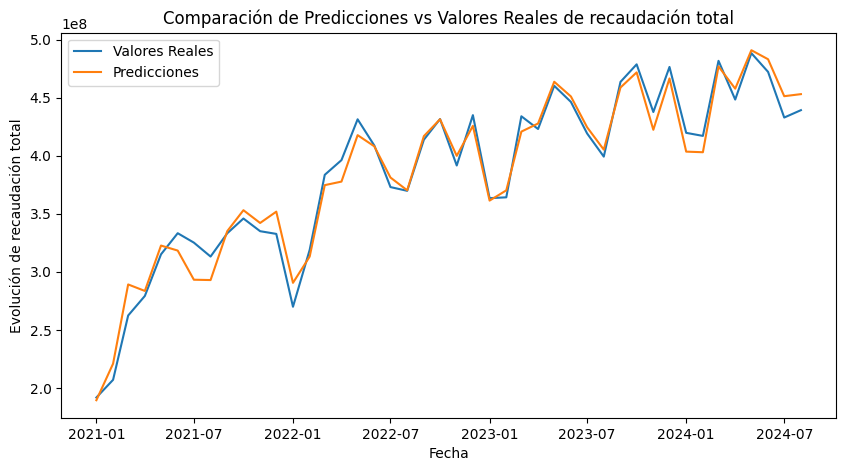

In [32]:
# Visualizar las predicciones junto con los valores reales
plt.figure(figsize=(10, 5))
plt.plot(df_amount['ds'], df_amount['y'], label='Valores Reales')
plt.plot(df_amount['ds'], y_pred, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Evolución de recaudación total')
plt.title('Comparación de Predicciones vs Valores Reales de recaudación total')
plt.legend()
plt.show()

**Emisión de Co2** total_co2_emission

11:01:45 - cmdstanpy - INFO - Chain [1] start processing
11:01:45 - cmdstanpy - INFO - Chain [1] done processing


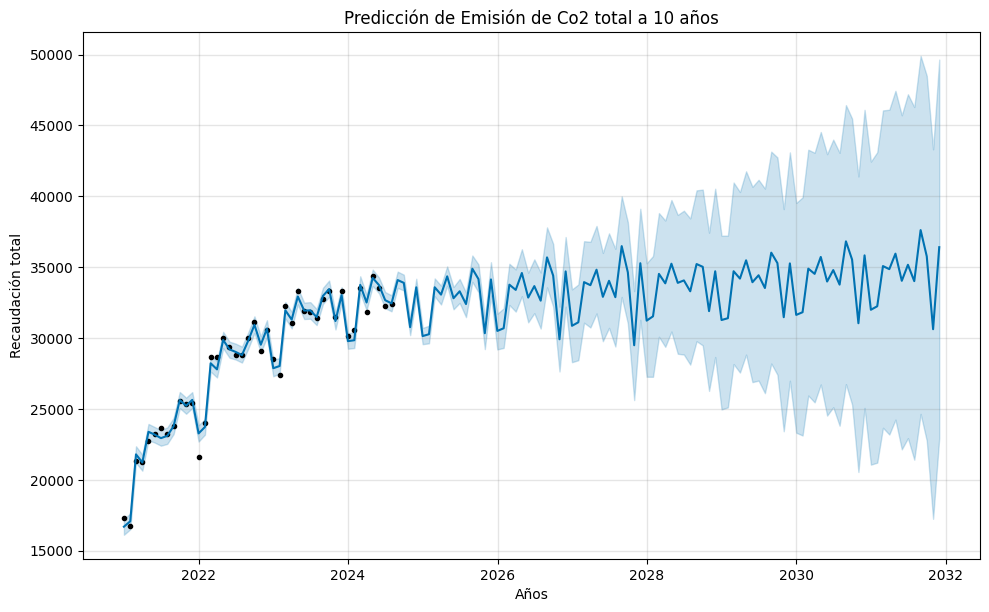

In [33]:
# Convertir el dataframe al formato requerido por Prophet
df_co2 = df_filtered.rename(columns={'date': 'ds', 'total_co2_emission': 'y'})

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(df_co2)

# Crear un dataframe con las fechas futuras para la predicción
future_dates = model.make_future_dataframe(periods=88, freq='ME')
forecast = model.predict(future_dates)

# Visualizar la predicción
fig = model.plot(forecast)
plt.xlabel('Años')
plt.ylabel('Recaudación total')
plt.title('Predicción de Emisión de Co2 total a 10 años')
plt.show()

In [34]:
y_true = df_co2['y']  # Valores reales
y_pred = forecast.loc[forecast['ds'].isin(df_co2['ds']), 'yhat']  # Predicciones en las fechas reales

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 322.60912467210636
RMSE: 444.944572029583
MAPE: 0.012334226556563082


In [35]:
co2_count = df_co2['y'].unique()
co2_count

array([17332.2978, 16725.9304, 21314.8925, 21265.8088, 22702.1115,
       23243.8214, 23666.8719, 23198.3687, 23816.6072, 25578.6904,
       25376.3002, 25436.881 , 21592.7111, 23977.4735, 28658.3417,
       28637.2394, 30026.8569, 29355.0022, 28825.6203, 28796.7434,
       29987.5918, 31122.5826, 29058.3977, 30584.471 , 28514.7988,
       27409.3925, 32235.5364, 31055.2288, 33285.6231, 31930.2578,
       31853.5448, 31398.2493, 32786.7727, 33309.6377, 31513.1292,
       33305.8377, 30172.3634, 30552.0927, 33508.2138, 31857.8272,
       34406.5904, 33526.1838, 32231.5815, 32427.8949])

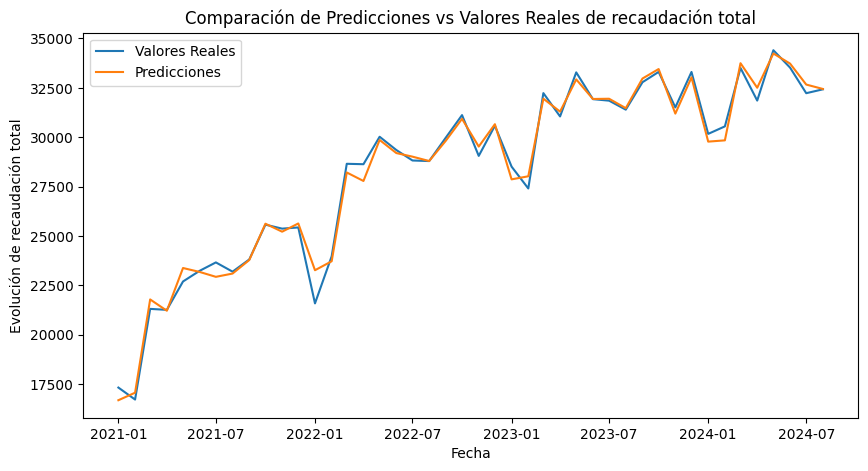

In [36]:
# Visualizar las predicciones junto con los valores reales
plt.figure(figsize=(10, 5))
plt.plot(df_co2['ds'], df_co2['y'], label='Valores Reales')
plt.plot(df_co2['ds'], y_pred, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Evolución de recaudación total')
plt.title('Comparación de Predicciones vs Valores Reales de recaudación total')
plt.legend()
plt.show()